In [17]:
df = pd.read_csv("ejections.csv", on_bad_lines="warn")


C:\Users\Bryan\AppData\Local\Temp\ipykernel_11756\3389023338.py:1: ParserWarning: Skipping line 1979: expected 11 fields, saw 12
Skipping line 1980: expected 11 fields, saw 12

  df = pd.read_csv("ejections.csv", on_bad_lines="warn")


In [18]:
import pandas as pd

# Assuming your CSV file is named 'data.csv' and in the same directory
df = pd.read_csv('ejections.csv')

print(df.head())


         GAMEID        DATE  DH   EJECTEE    EJECTEENAME TEAM JOB    UMPIRE  \
0  CL6188905250  05/25/1889 NaN  orr-d101       Dave Orr  CL6   P  goldf101   
1  BL2188905280  05/28/1889 NaN  tuckt103   Tommy Tucker  BL2   P  gaffj801   
2  WS8188906010  06/01/1889 NaN  ewinb101     Buck Ewing  NY1   P  currw101   
3  WS8188907300  07/30/1889 NaN  ewinb101     Buck Ewing  NY1   P  bakep101   
4  LS2188908100  08/10/1889 NaN  raymh101  Harry Raymond  LS2   P  goldf101   

       UMPIRENAME  INNING                     REASON  
0  Fred Goldsmith      -1                 Call at 3B  
1    John Gaffney      -1  Yelling at OF chasing fly  
2       Wes Curry      -1           Obscene language  
3      Phil Baker      -1                 Call at 1B  
4  Fred Goldsmith      -1                 Call at 2B  


In [24]:
import pandas as pd

# 1. Load data
ejections = pd.read_csv("ejections.csv")  # adjust path if needed
scorecards = pd.read_csv("data/mlb-umpire-scorecard.csv")

# 2. Parse dates
ejections["DATE"] = pd.to_datetime(ejections["DATE"], format="%m/%d/%Y", errors="coerce")
scorecards["date"] = pd.to_datetime(scorecards["date"], errors="coerce")

# 3. Filter ejections to 2015–2021
mask = (ejections["DATE"].dt.year >= 2015) & (ejections["DATE"].dt.year <= 2021)
ejections_filtered = ejections[mask].copy()

# 4. Clean strings (remove extra spaces)
ejections_filtered["UMPIRENAME"] = ejections_filtered["UMPIRENAME"].str.strip()
ejections_filtered["TEAM"] = ejections_filtered["TEAM"].str.strip()

scorecards["umpire"] = scorecards["umpire"].str.strip()
scorecards["home"] = scorecards["home"].str.strip()
scorecards["away"] = scorecards["away"].str.strip()

# 5. Merge where TEAM is the HOME team
home_overlap = pd.merge(
    ejections_filtered,
    scorecards,
    left_on=["UMPIRENAME", "TEAM", "DATE"],
    right_on=["umpire", "home", "date"],
    how="inner",
    suffixes=("_ej", "_sc"),
)

# 6. Merge where TEAM is the AWAY team
away_overlap = pd.merge(
    ejections_filtered,
    scorecards,
    left_on=["UMPIRENAME", "TEAM", "DATE"],
    right_on=["umpire", "away", "date"],
    how="inner",
    suffixes=("_ej", "_sc"),
)

# 7. Combine home + away matches and drop duplicates
overlap = pd.concat([home_overlap, away_overlap], ignore_index=True).drop_duplicates()

print("Number of overlapping rows:", len(overlap))
print("Date range in overlap:", overlap["DATE"].min(), "to", overlap["DATE"].max())

# 8. Save output
overlap.to_csv("output.csv", index=False)
print("Saved to output.csv")


Number of overlapping rows: 586
Date range in overlap: 2015-04-10 00:00:00 to 2021-09-25 00:00:00
Saved to output.csv


In [25]:
df = pd.read_csv("output.csv")

In [26]:
df.columns


Index(['GAMEID', 'DATE', 'DH', 'EJECTEE', 'EJECTEENAME', 'TEAM', 'JOB',
       'UMPIRE', 'UMPIRENAME', 'INNING', 'REASON', 'id', 'date', 'umpire',
       'home', 'away', 'home_team_runs', 'away_team_runs', 'pitches_called',
       'incorrect_calls', 'expected_incorrect_calls', 'correct_calls',
       'expected_correct_calls', 'correct_calls_above_expected', 'accuracy',
       'expected_accuracy', 'accuracy_above_expected', 'consistency',
       'favor_home', 'total_run_impact'],
      dtype='object')

In [27]:
# 1. Identify whether the ejected team is HOME or AWAY
df["is_home"] = df["TEAM"] == df["home"]
df["is_away"] = df["TEAM"] == df["away"]

In [29]:
# 2. Determine whether the ejected team won the game
def team_won(row):
    if row["is_home"]:
        return row["home_team_runs"] > row["away_team_runs"]
    elif row["is_away"]:
        return row["away_team_runs"] > row["home_team_runs"]
    return None  # should not occur

df["team_won"] = df.apply(team_won, axis=1)

In [31]:
# 3. Summaries
total_games = df["team_won"].notna().sum()
wins = df["team_won"].sum()       # True = win
losses = total_games - wins

win_pct = wins / total_games
loss_pct = losses / total_games

print("Total games with an ejection match:", total_games)
print("Wins after ejection:", wins)
print("Losses after ejection:", losses)
print("Win %:", round(win_pct, 3))
print("Loss %:", round(loss_pct, 3))

Total games with an ejection match: 586
Wins after ejection: 201
Losses after ejection: 385
Win %: 0.343
Loss %: 0.657


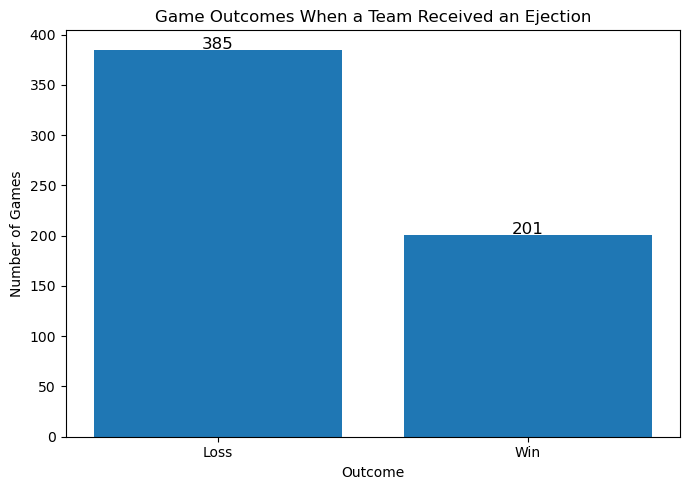

In [34]:
# Count wins and losses
counts = df["team_won"].value_counts().rename({True: "Win", False: "Loss"})

import matplotlib.pyplot as plt

# Plot bar chart
plt.figure(figsize=(7,5))
plt.bar(counts.index, counts.values)

plt.title("Game Outcomes When a Team Received an Ejection")
plt.xlabel("Outcome")
plt.ylabel("Number of Games")

# Add values above bars
for i, value in enumerate(counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [35]:
import time
import requests
import pandas as pd

SCHEDULE_URL = "https://statsapi.mlb.com/api/v1/schedule"
GAME_FEED_URL = "https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live"


def get_game_pk(game_date: str, home_abbr: str, away_abbr: str | None = None) -> int | None:
    """
    Use MLB StatsAPI schedule endpoint to find the gamePk for a given date and home team.
    Optionally also match on away team to avoid ambiguity (doubleheaders, etc.).
    """
    params = {
        "sportId": 1,   # MLB
        "date": game_date,
        # you *can* filter by gameType ("R" for regular season), but it's optional:
        # "gameType": "R",
    }
    resp = requests.get(SCHEDULE_URL, params=params, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    for date_block in data.get("dates", []):
        for g in date_block.get("games", []):
            home = g["teams"]["home"]["team"].get("abbreviation") or g["teams"]["home"]["team"].get("teamCode")
            away = g["teams"]["away"]["team"].get("abbreviation") or g["teams"]["away"]["team"].get("teamCode")

            # basic match: date + home team; if away_abbr is given, require that too
            if home == home_abbr and (away_abbr is None or away == away_abbr):
                return g["gamePk"]

    # No match found
    return None


def get_weather_for_game(game_pk: int | None):
    """
    Given a gamePk, call the MLB game feed endpoint and return weather info.
    Returns (condition, temp, wind) or (None, None, None) if unavailable.
    """
    if game_pk is None:
        return None, None, None

    url = GAME_FEED_URL.format(game_pk=game_pk)
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    weather = data.get("gameData", {}).get("weather", {}) or {}
    condition = weather.get("condition")
    temp = weather.get("temp")
    wind = weather.get("wind")

    return condition, temp, wind


def main():
    # 1. Load your overlap file (the one you called output.csv)
    df = pd.read_csv("output.csv")

    # Make sure DATE is in YYYY-MM-DD format as strings
    df["DATE"] = pd.to_datetime(df["DATE"]).dt.strftime("%Y-%m-%d")

    # We’ll use a cache so we only hit the API once per unique game
    # key: (DATE, home, away) -> (condition, temp, wind)
    weather_cache: dict[tuple[str, str, str], tuple[str | None, str | None, str | None]] = {}

    weather_condition = []
    weather_temp = []
    weather_wind = []

    for idx, row in df.iterrows():
        game_date = row["DATE"]
        home_team = row["home"]
        away_team = row["away"]  # you *could* skip this and just use home_team if you want

        key = (game_date, home_team, away_team)

        if key not in weather_cache:
            try:
                game_pk = get_game_pk(game_date, home_team, away_team)
                condition, temp, wind = get_weather_for_game(game_pk)
            except Exception as e:
                print(f"Row {idx}: error fetching weather for {key}: {e}")
                condition, temp, wind = None, None, None

            weather_cache[key] = (condition, temp, wind)

            # Be nice to the API
            time.sleep(0.2)

        condition, temp, wind = weather_cache[key]
        weather_condition.append(condition)
        weather_temp.append(temp)
        weather_wind.append(wind)

    # 3. Attach the new columns
    df["weather_condition"] = weather_condition
    df["weather_temp"] = weather_temp
    df["weather_wind"] = weather_wind

    # 4. Save to a new CSV
    df.to_csv("output_with_weather.csv", index=False)
    print("Saved file: output_with_weather.csv")


if __name__ == "__main__":
    main()


Saved file: output_with_weather.csv


In [38]:
import requests

date = "2015-04-10"
home = "MIL"
away = "PIT"

# Map 3-letter abbreviations to city or full name fragments
ABBR_TO_CITY = {
    "ARI": "Arizona",
    "ATL": "Atlanta",
    "BAL": "Baltimore",
    "BOS": "Boston",
    "CHC": "Chicago Cubs",
    "CHW": "Chicago White Sox",
    "CIN": "Cincinnati",
    "CLE": "Cleveland",
    "COL": "Colorado",
    "DET": "Detroit",
    "HOU": "Houston",
    "KCR": "Kansas City",
    "KCR": "Kansas City",
    "KCR": "Kansas City",
    "KCR": "Kansas City",
    "LAA": "Los Angeles Angels",
    "LAD": "Los Angeles Dodgers",
    "MIA": "Miami",
    "MIL": "Milwaukee",
    "MIN": "Minnesota",
    "NYM": "New York Mets",
    "NYY": "New York Yankees",
    "OAK": "Oakland",
    "PHI": "Philadelphia",
    "PIT": "Pittsburgh",
    "SDP": "San Diego",
    "SEA": "Seattle",
    "SFG": "San Francisco",
    "STL": "St. Louis",
    "TBR": "Tampa Bay",
    "TEX": "Texas",
    "TOR": "Toronto",
    "WSH": "Washington",
}

def abbr_to_city(abbr: str) -> str:
    return ABBR_TO_CITY.get(abbr.upper(), abbr)

def get_game_pk(game_date, home_abbr, away_abbr):
    url = "https://statsapi.mlb.com/api/v1/schedule"
    params = {"sportId": 1, "date": game_date}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    if not data.get("dates"):
        print("No games found on this date.")
        return None

    home_target = abbr_to_city(home_abbr).upper()
    away_target = abbr_to_city(away_abbr).upper()

    print("Games returned by MLB API on this date:")
    for d in data["dates"]:
        for g in d["games"]:
            home_name = g["teams"]["home"]["team"]["name"]
            away_name = g["teams"]["away"]["team"]["name"]
            print(g["gamePk"], away_name, "at", home_name)

    # Match by city substring in the full name
    for d in data["dates"]:
        for g in d["games"]:
            home_name = g["teams"]["home"]["team"]["name"].upper()
            away_name = g["teams"]["away"]["team"]["name"].upper()

            if home_target in home_name and away_target in away_name:
                print("\nMatched game:", g["gamePk"], away_name, "at", home_name)
                return g["gamePk"]

    print("No matching game found for", game_date, home_abbr, "vs", away_abbr)
    return None


def get_weather(game_pk):
    if game_pk is None:
        print("No gamePk found.")
        return

    url = f"https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    weather = data.get("gameData", {}).get("weather", {}) or {}
    print("\nWeather object from API:")
    print(weather)
    return weather


# ----- RUN TEST -----
game_pk = get_game_pk(date, home, away)
print("\nFound gamePk:", game_pk)

weather = get_weather(game_pk)
print("\nFinal extracted weather:", weather)


Games returned by MLB API on this date:
413709 Toronto Blue Jays at Baltimore Orioles
413699 Houston Astros at Texas Rangers
413697 Chicago Cubs at Colorado Rockies
413698 Detroit Tigers at Cleveland Indians
413702 Minnesota Twins at Chicago White Sox
413710 Washington Nationals at Philadelphia Phillies
413696 Boston Red Sox at New York Yankees
413707 St. Louis Cardinals at Cincinnati Reds
413708 Tampa Bay Rays at Miami Marlins
413703 New York Mets at Atlanta Braves
413704 Pittsburgh Pirates at Milwaukee Brewers
413701 Los Angeles Dodgers at Arizona Diamondbacks
413700 Kansas City Royals at Los Angeles Angels
413705 Seattle Mariners at Oakland Athletics
413706 San Francisco Giants at San Diego Padres

Matched game: 413704 PITTSBURGH PIRATES at MILWAUKEE BREWERS

Found gamePk: 413704

Weather object from API:
{'condition': 'Roof Closed', 'temp': '66', 'wind': '0 mph, None'}

Final extracted weather: {'condition': 'Roof Closed', 'temp': '66', 'wind': '0 mph, None'}


In [40]:
import time
import requests
import pandas as pd

INPUT_CSV = "output.csv"
OUTPUT_CSV = "output_with_weather.csv"

ABBR_TO_CITY = {
    "ARI": "Arizona",
    "ATL": "Atlanta",
    "BAL": "Baltimore",
    "BOS": "Boston",
    "CHC": "Chicago Cubs",
    "CHW": "Chicago White Sox",
    "CIN": "Cincinnati",
    "CLE": "Cleveland",
    "COL": "Colorado",
    "DET": "Detroit",
    "HOU": "Houston",
    "KCR": "Kansas City",
    "LAA": "Los Angeles Angels",
    "LAD": "Los Angeles Dodgers",
    "MIA": "Miami",
    "MIL": "Milwaukee",
    "MIN": "Minnesota",
    "NYM": "New York Mets",
    "NYY": "New York Yankees",
    "OAK": "Oakland",
    "PHI": "Philadelphia",
    "PIT": "Pittsburgh",
    "SDP": "San Diego",
    "SEA": "Seattle",
    "SFG": "San Francisco",
    "STL": "St. Louis",
    "TBR": "Tampa Bay",
    "TEX": "Texas",
    "TOR": "Toronto",
    "WSH": "Washington",
}

def abbr_to_city(abbr: str | float) -> str:
    if pd.isna(abbr):
        return ""
    return ABBR_TO_CITY.get(str(abbr).upper(), str(abbr))

def get_game_pk(game_date, home_abbr, away_abbr):
    url = "https://statsapi.mlb.com/api/v1/schedule"
    params = {"sportId": 1, "date": game_date}
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    data = r.json()

    if not data.get("dates"):
        return None

    home_target = abbr_to_city(home_abbr).upper()
    away_target = abbr_to_city(away_abbr).upper()

    # Search through returned games
    for d in data["dates"]:
        for g in d["games"]:
            home_name = g["teams"]["home"]["team"]["name"].upper()
            away_name = g["teams"]["away"]["team"]["name"].upper()

            # Require home match
            if home_target not in home_name:
                continue

            # If we have away team, also match that
            if away_target and away_target not in away_name:
                continue

            return g["gamePk"]

    return None

def get_weather_for_game(game_pk):
    if game_pk is None:
        return None, None, None

    url = f"https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live"
    r = requests.get(url, timeout=10)
    r.raise_for_status()
    data = r.json()

    weather = data.get("gameData", {}).get("weather", {}) or {}
    condition = weather.get("condition")
    temp = weather.get("temp")
    wind = weather.get("wind")
    return condition, temp, wind


def main():
    df = pd.read_csv(INPUT_CSV)

    # Normalize DATE to YYYY-MM-DD
    df["DATE"] = pd.to_datetime(df["DATE"]).dt.strftime("%Y-%m-%d")

    weather_condition = []
    weather_temp = []
    weather_wind = []

    cache = {}  # (date, home, away) -> (cond, temp, wind)

    for idx, row in df.iterrows():
        game_date = row["DATE"]
        home = row["home"]
        away = row["away"]

        key = (game_date, home, away)

        if key not in cache:
            try:
                game_pk = get_game_pk(game_date, home, away)
                cond, temp, wind = get_weather_for_game(game_pk)
            except Exception as e:
                print(f"Row {idx}: error for {key}: {e}")
                cond, temp, wind = None, None, None

            cache[key] = (cond, temp, wind)
            time.sleep(0.2)  # Do not spam MLB API calls

        cond, temp, wind = cache[key]
        weather_condition.append(cond)
        weather_temp.append(temp)
        weather_wind.append(wind)

    df["weather_condition"] = weather_condition
    df["weather_temp"] = weather_temp
    df["weather_wind"] = weather_wind

    df.to_csv(OUTPUT_CSV, index=False)
    print("Saved:", OUTPUT_CSV)


if __name__ == "__main__":
    main()


Saved: output_with_weather.csv


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit bigger
plt.rcParams["figure.figsize"] = (12, 6)

# -------------------------------------------------------------------
# 0. Load data and basic cleaning
# -------------------------------------------------------------------
df = pd.read_csv("output_with_weather.csv")

# Make sure temperature is numeric
df["weather_temp"] = pd.to_numeric(df["weather_temp"], errors="coerce")

# Some charts need numeric accuracy too (should already be numeric, but just in case)
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")


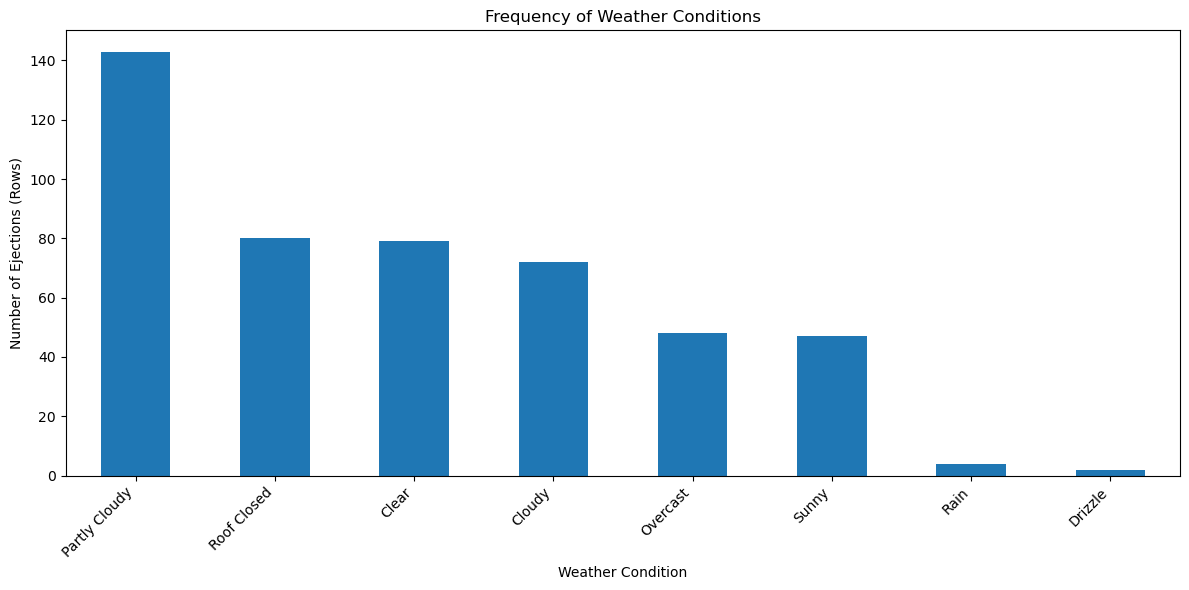

In [42]:
cond_counts = df["weather_condition"].value_counts().sort_values(ascending=False)

plt.figure()
cond_counts.plot(kind="bar")
plt.title("Frequency of Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Ejections (Rows)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


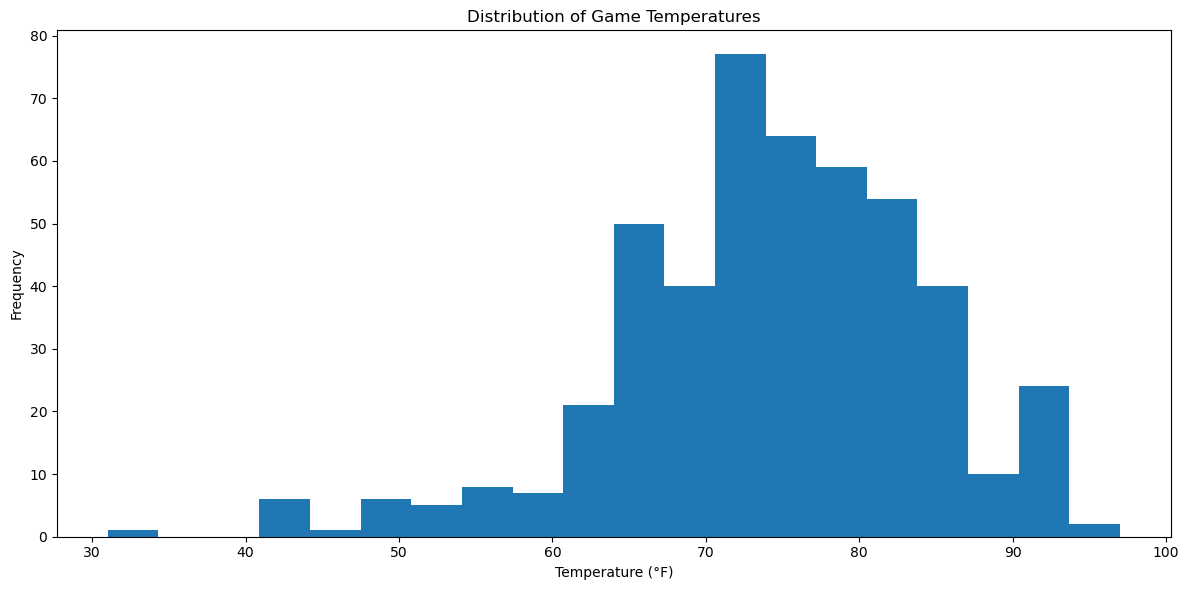

In [43]:
plt.figure()
df["weather_temp"].dropna().plot(kind="hist", bins=20)
plt.title("Distribution of Game Temperatures")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


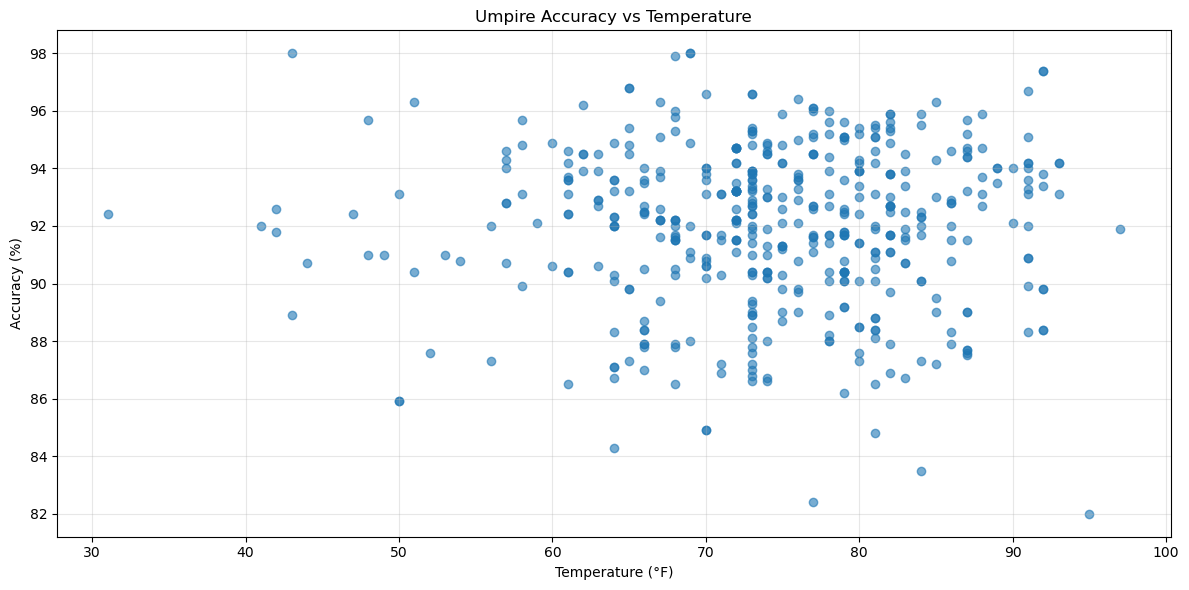

Correlation between temperature and accuracy:
              weather_temp  accuracy
weather_temp      1.000000  0.014015
accuracy          0.014015  1.000000


In [44]:
# Drop rows missing either temp or accuracy
temp_acc = df[["weather_temp", "accuracy"]].dropna()

# Scatter plot
plt.figure()
plt.scatter(temp_acc["weather_temp"], temp_acc["accuracy"], alpha=0.6)
plt.title("Umpire Accuracy vs Temperature")
plt.xlabel("Temperature (°F)")
plt.ylabel("Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
print("Correlation between temperature and accuracy:")
print(temp_acc.corr())
